# Machine Learning - Brain Tumor Detection
#### dataset source - Kaggle

- Data samples in the beginning        - 4600 units
- Data samples after cleaning the data - 4461 units

#### After the Data Cleaning:
- 2421 samples with brain tumor and the other 2040 without.
- All samples resized to fixed size and convert to gray HOG images.

### Models Tested:
- Logistic Regression
- KNN Classifier
- SGD Classifier

### Choosing Model:
The Suitable Model was the Logistic Regression with Training Accuracy (Avg.) of ~0.95 
which was close to the other two models.

### The Logistic Regressiom Test Results was 96.19% of Accuracy.
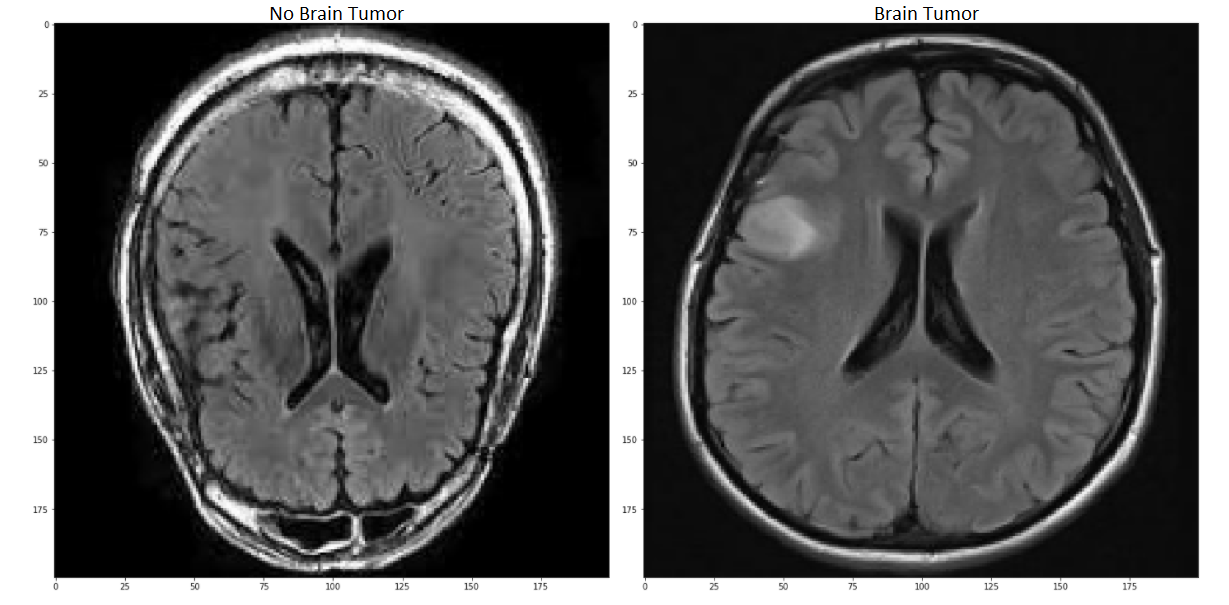


### Libraries Used:

In [105]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import warnings
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler
import skimage
from skimage.feature import hog
from skimage.transform import rescale
from skimage.io import imread
from skimage.transform import resize
from collections import Counter

### Loading the Data & Inspecting it

In [106]:
data = pd.read_csv("Datasets/Brain Tumor Data Set/BrainTumorDataset.csv")
print("Samples: {}".format(data.shape[0]))
data.head(5)


Samples: 4600


Unnamed: 0            image  class format mode          shape
0           0   Cancer (1).jpg  tumor   JPEG  RGB  (512, 512, 3)
1           1   Cancer (1).png  tumor    PNG    L     (300, 240)
2           2   Cancer (1).tif  tumor   TIFF  RGB  (256, 256, 3)
3           3  Cancer (10).jpg  tumor   JPEG  RGB  (512, 512, 3)
4           4  Cancer (10).tif  tumor   TIFF  RGB  (256, 256, 3)

## Cleaning The Data
#### - Remove the unnecessary information
#### - Change the Class Column to Binary Value: 0/1
#### - Merging the new data to one Table

In [107]:
tclass = pd.get_dummies(data["class"],drop_first=True)
data.drop(["Unnamed: 0", "format", "mode", "class", "shape"], axis=1, inplace=True)
data = pd.concat([data, tclass], axis=1)
data.head(5)

image  tumor
0   Cancer (1).jpg      1
1   Cancer (1).png      1
2   Cancer (1).tif      1
3  Cancer (10).jpg      1
4  Cancer (10).tif      1

#### Resizing All of The Samples the fixed Size & Creating new PKL file to store the new Data:

In [108]:
def resize_all(dataset, path, pklname, width=200, height=200): 
    data = dict()
    data['tumor'] = []
    data['data'] = []   
    
    pklname = f"{pklname}.pkl"
    
    for i, row in dataset.iterrows():
        filename = row[0]
        value = row[1]
        filepath = os.path.join(path, filename)
        im = imread(filepath)
        im = resize(im, (width, height)) 
        data['tumor'].append(value)
        data['data'].append(im)
            
    joblib.dump(data, pklname)

In [109]:
resize_all(dataset=data, path='Datasets/Brain Tumor Data Set/Brain Tumor Data Set', pklname='PreparedData')

In [110]:
data = joblib.load('PreparedData.pkl')

##### Ignoring the samples with different format & Get Information about Final Data:

In [111]:
X = []
y = []

for i in range(len(data['data'])):
    if data['data'][i].shape == (200, 200,3):
    	X.append(data['data'][i])
    	y.append(data['tumor'][i])
        
print('samples: ', len(X))
print('image dimm: ', X[0].shape)
print('values:', np.unique(y))
Counter(y)

samples:  4461
image dimm:  (200, 200, 3)
values: [0 1]


Counter({1: 2421, 0: 2040})

### Example of the Images:

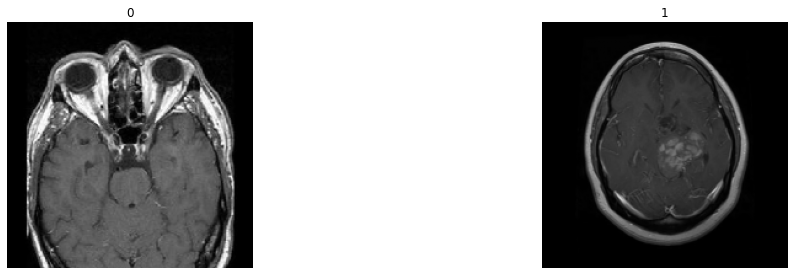

In [112]:
labels = np.unique(y)
 
fig, axes = plt.subplots(1, len(labels))
fig.set_size_inches(15,4)
fig.tight_layout()
 
for ax, label in zip(axes, labels):
    idx = y.index(label)
     
    ax.imshow(X[idx])
    ax.axis('off')
    ax.set_title(label)

### Divide The Data:
#### - 80% of the Data for Training thr model
#### - 20% of the Data for Testing thr model

In [113]:
X = np.array(X)
y = np.array(y)
data = None
X_train, X_test, y_train,  y_test = train_test_split(X, y, test_size=0.2, random_state=1)

## Classes for Transforming the Data to more Usable form:
- Transform all the images from RGB format into Grey format
- Transform all the images to HOG (Histogram of Oriented Gradients) format

In [114]:
from sklearn.base import BaseEstimator, TransformerMixin
 
class RGB2GrayTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
 
    def fit(self, X, y=None):
        return self
 
    def transform(self, X, y=None):
        return np.array([skimage.color.rgb2gray(img) for img in X])
     
class HogTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, y=None, orientations=9,
                 pixels_per_cell=(8, 8),
                 cells_per_block=(3, 3), block_norm='L2-Hys'):
        self.y = y
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.block_norm = block_norm
 
    def fit(self, X, y=None):
        return self
 
    def transform(self, X, y=None):
 
        def local_hog(X):
            return hog(X,
                       orientations=self.orientations,
                       pixels_per_cell=self.pixels_per_cell,
                       cells_per_block=self.cells_per_block,
                       block_norm=self.block_norm)
 
        try:
            return np.array([local_hog(img) for img in X])
        except:
            return np.array([local_hog(img) for img in X])

In [115]:
grayify = RGB2GrayTransformer()
hogify = HogTransformer(
    pixels_per_cell=(14, 14), 
    cells_per_block=(2,2), 
    orientations=9, 
    block_norm='L2-Hys'
)
scalify = StandardScaler()
X_train_gray = grayify.fit_transform(X_train)
X_train_hog = hogify.fit_transform(X_train_gray)
X_train_prepared = scalify.fit_transform(X_train_hog)

### Training the Different Models:
- Logistic Regression
- KNN Classifier
- SGD Classifie

### As the diagram shows, the Logistic Regression is The most Accurate of the three
the Logistic Regression with Training Accuracy (Avg.) of ~0.95 

LR: 0.956281 (0.005467)
KNN: 0.942265 (0.012852)
SGD: 0.940309 (0.011111)


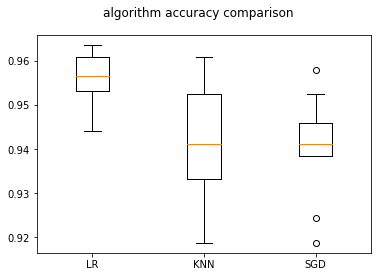

In [116]:
seed = 8
models = []
models.append(('LR', LogisticRegression(random_state=seed)))
models.append(('KNN', KNeighborsClassifier()))
models.append(('SGD', SGDClassifier(random_state=seed, max_iter=1000, tol=1e-3)))

# warnings.filterwarnings('ignore')


results = []
names   = []

for name, model in models:
    kfold = KFold(n_splits=10, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model, X_train_prepared, y_train, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

fig = plt.figure()
fig.suptitle('algorithm accuracy comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

## Testing The Model:
#### After Choosing the Logistic Regression, Compare its results to the actual Diagnosis.

Note: Needless to say that the Trainig Data and The Testing Data Are Different as we split the data in 0.8/0.2 ratio. Therefore, the testing data is unfamiliar to the model. 

In [117]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

X_test_gray = grayify.fit_transform(X_test)
X_test_hog = hogify.fit_transform(X_test_gray)
X_test_prepared = scalify.fit_transform(X_test_hog)

model = LogisticRegression(random_state=seed)
model.fit(X_train_prepared, y_train)

predictions = model.predict(X_test_prepared)

## Results:
#### - The Logistic Regressiom Test Results was 96.19% of Accuracy.
#### - Out of  404 samples that The model Predict to have a brain tumor, 383 Actually have a tumor.
#### - Out of  455 samples that The model Predict to not have a brain tumor, 434 Actually not have a tumor.

In [118]:
print("Accuracy Score: {}% out of 100%".format(accuracy_score(y_test, predictions)*100))
print("Confusion Matrix:")
print(confusion_matrix(y_test, predictions))

Accuracy Score: 96.1926091825308% out of 100%
Confusion Matrix:
[[404  13]
 [ 21 455]]


### Examples of the Model Results

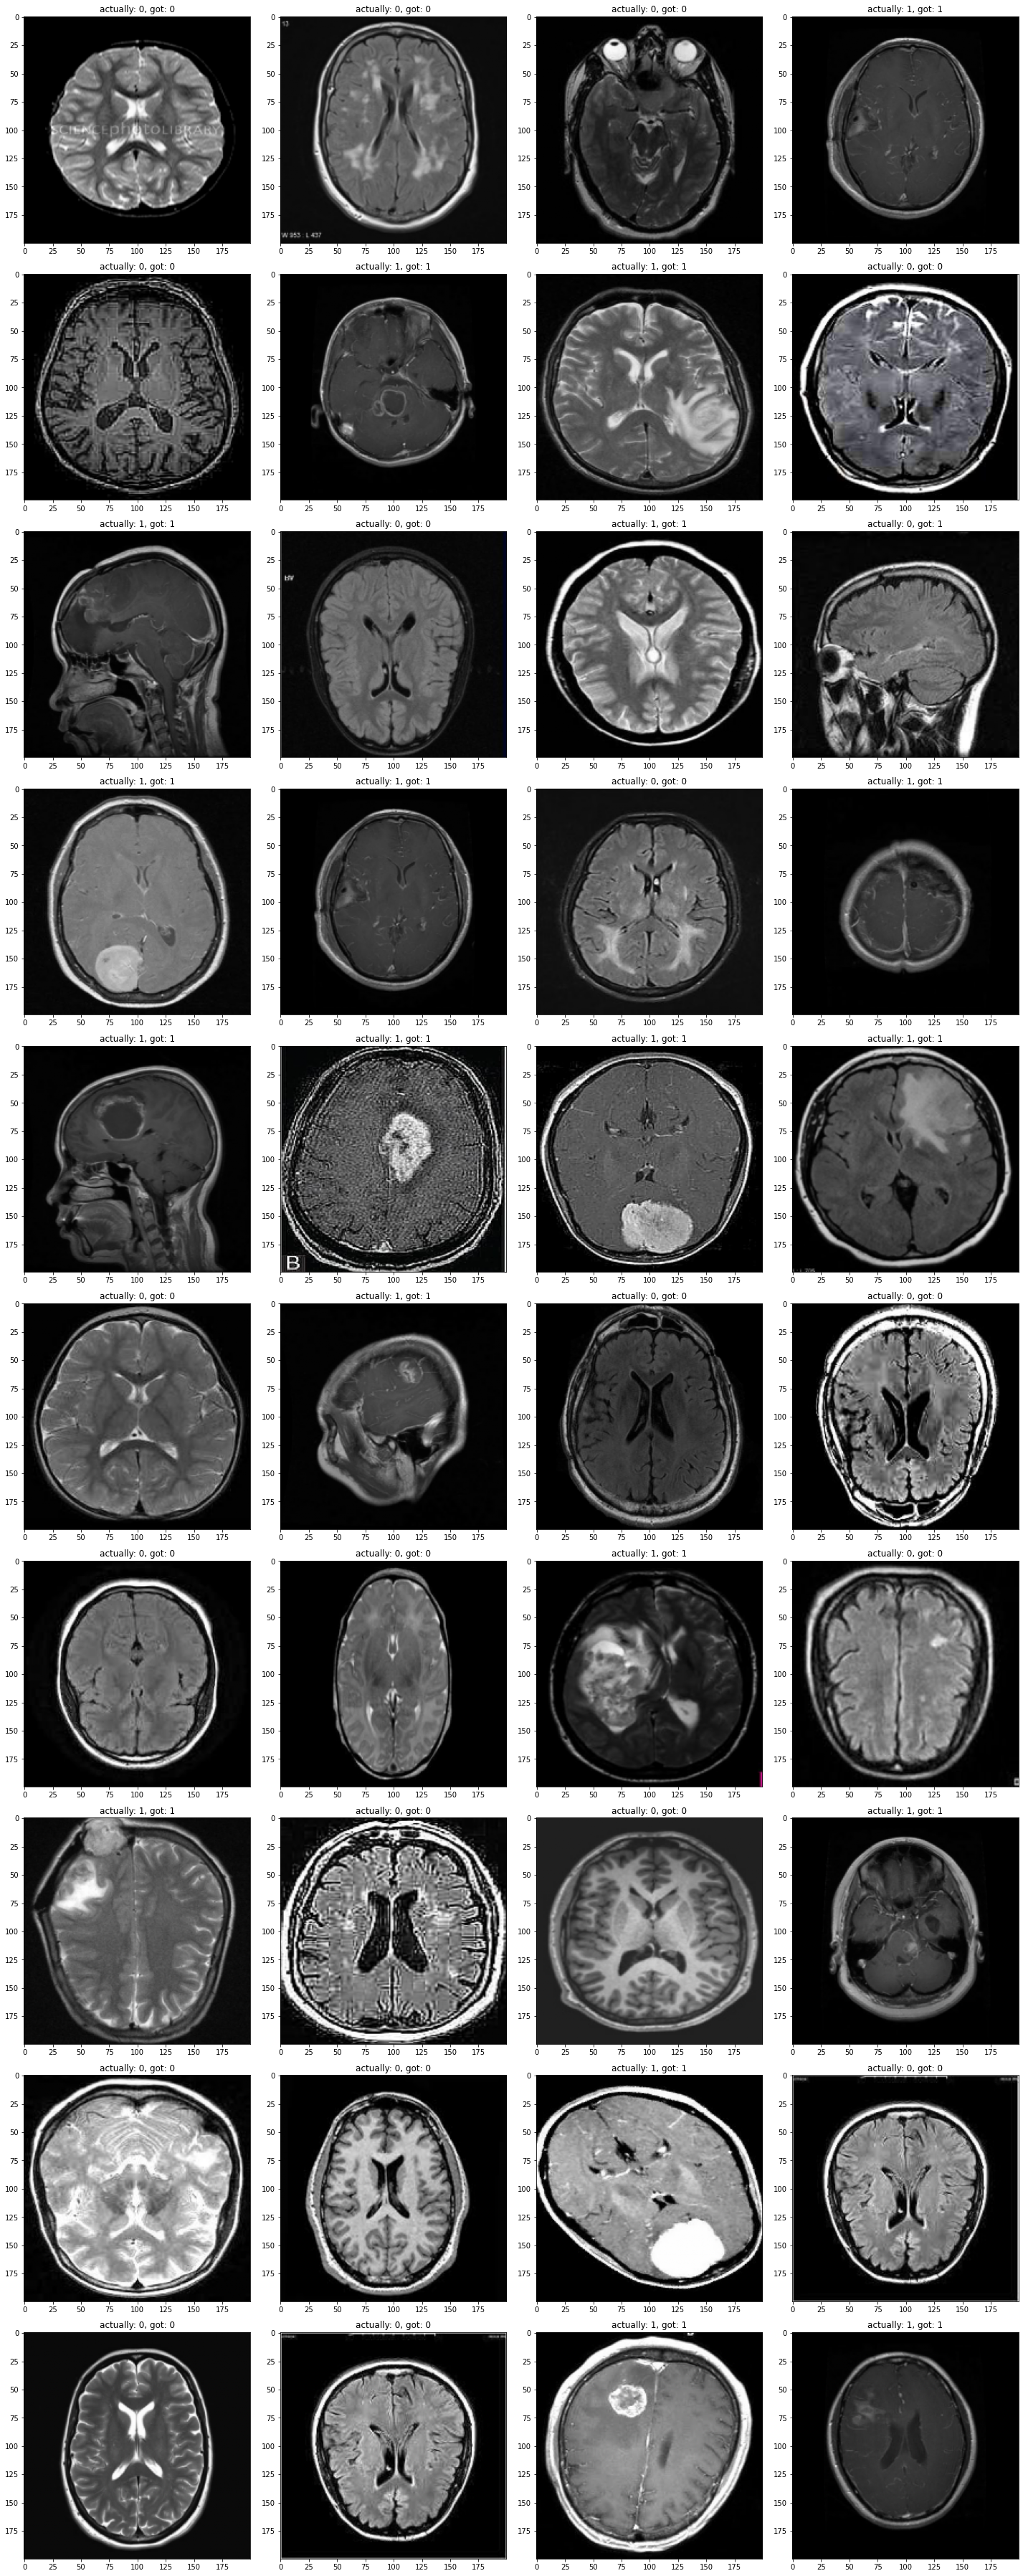

In [119]:
from random import randint
fig, axes = plt.subplots(10, 4)
fig.set_size_inches(20,50)
fig.tight_layout()
 
i = 0
for x in range(10):
    for y in range(4):
        i = randint(0, len(y_test))
        axes[x][y].imshow(X_test[i])
        axes[x][y].set_title("actually: {}, got: {}".format(y_test[i], predictions[i],i))